<a href="https://colab.research.google.com/github/shinanna/Tripadvisor_NLP_Analysis/blob/main/Tripadvisor_NLP_Filter_Data_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tripadvisor NLP Filter | Data Modeling

## Imports

The latest version of Matplotlib is needed to plot graphs with value labels. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

import re
import string
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import requests

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
!pip install --upgrade matplotlib

In [3]:
import matplotlib
matplotlib.__version__

'3.5.1'

In [4]:
# set plot parameters
sns.set_theme(style="darkgrid", palette="crest")

from google.colab import files

uploaded = files.upload()

import io

data = pd.read_csv(io.BytesIO(uploaded['Tripadvisor_Septime_clean.csv']), encoding ="utf-8")

In [5]:
# import dataset from github
url = 'https://raw.githubusercontent.com/shinanna/Tripadvisor_NLP_Analysis/main/datasets/Tripadvisor_Septime_clean.csv'
data = pd.read_csv(url)

## Textual data cleaning

### Data info

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rev_title       329 non-null    object
 1   author          329 non-null    object
 2   author_reviews  329 non-null    int64 
 3   ratingdate      329 non-null    object
 4   text            329 non-null    object
 5   visitdate       329 non-null    object
 6   likes           329 non-null    int64 
 7   rating          329 non-null    int64 
 8   weekday         329 non-null    object
 9   month           329 non-null    object
dtypes: int64(3), object(7)
memory usage: 25.8+ KB


In [7]:
data.head()

,rev_title,author,author_reviews,ratingdate,text,visitdate,likes,rating,weekday,month
0,great for vegetarians,Turner S,762,2021-08-14,Have been lucky enough to enjoy their food a f...,2021-07-01,0,4,Saturday,August
1,Spend your money somewhere else.,758shelinas,24,2021-08-06,We have visited Septime last Tuesday after wai...,2021-08-01,2,1,Friday,August
2,Spectacular - our high expectations were met,bluesky2020a,82,2020-07-27,We got a reservation at Septime a couple of mo...,2020-07-01,1,5,Monday,July
3,Groumet as I'm used to,Sinyanchway,4,2020-03-10,We were invited here by our business parter an...,2020-02-01,3,5,Tuesday,March
4,"If you can get a table, you're in for the meal...",Sophie F,31,2020-02-21,"Took me years to secure a reservation, but it ...",2020-02-01,2,5,Friday,February


Data is clean, let's extract only on the columns which will be useful for our NLP analysis.

In [8]:
# drop all columns irrelevant for NLP analysis
data.drop(['rev_title', 'author', 'author_reviews', 'ratingdate', 'visitdate', 'likes', 'weekday', 'month'], axis=1, inplace=True)
data.columns

Index(['text', 'rating'], dtype='object')

## Textual Data preprocessing

### Expand contractions

Create a new column with text reworked to replace contractions by formal English and help the machine  processing grouped expressions. 

In [9]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text, contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
data['cleaned'] = data['text'].apply(lambda x:expand_contractions(x))
data['cleaned'][10]

'I am in Paris a fewtimes every year, and after having tried many times to get a reservation at "Septime" unsuccessfully, it finally worked out last week. Paris is a city blessed with quite a few excellent restaurants, so one must wonder how the incredible hype about this particular one is even possible,let alone for so many years. I was really sceptical, but did not try to create any special expectations, since I know this is how you get disappointed many times. Having the experience of dining at Septime now, I understand better why itis sohard toget a table there. First of all, it is quite a small place, with few tables.The atmoshphere is quite low key, but everything fits nicely into the picture, fromthe silverware to the flowers which seem to have been picked in the garden and then put into an old glass jar. The staff is casual and very friendly. The food is conceived of and prepared very meticulously and which much taste, but comes across effortlessly. This is where cooking and se

### Clean uppercase and special characters

In [10]:
# Lowercase the reviews
data['cleaned'] = data['text'].apply(lambda x: x.lower())

# Remove restaurant name and word
words_to_remove = ['septime', 'restaurant']
for word in words_to_remove:
  data['cleaned'] = data['cleaned'].apply(lambda x: re.sub(word,'', x))

# Remove new line separators
data['cleaned'] = data['cleaned'].apply(lambda x: re.sub('\n','', x))

# Remove digits and words containing digits
data['cleaned'] = data['cleaned'].apply(lambda x: re.sub('\w*\d\w*','', x))

# Remove Punctuations
data['cleaned'] = data['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Remove extra spaces
data['cleaned'] = data['cleaned'].apply(lambda x: re.sub(' +',' ',x))

data[['text', 'cleaned']].head()

,text,cleaned
0,Have been lucky enough to enjoy their food a f...,have been lucky enough to enjoy their food a f...
1,We have visited Septime last Tuesday after wai...,we have visited last tuesday after waiting for...
2,We got a reservation at Septime a couple of mo...,we got a reservation at a couple of months aft...
3,We were invited here by our business parter an...,we were invited here by our business parter an...
4,"Took me years to secure a reservation, but it ...",took me years to secure a reservation but it d...


### Lemmatization

In [11]:
# Loading model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization with stopwords removal
data['lemmatized'] = data['cleaned'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

data[['text', 'cleaned', 'lemmatized']].head()

,text,cleaned,lemmatized
0,Have been lucky enough to enjoy their food a f...,have been lucky enough to enjoy their food a f...,lucky enjoy food time recommend vegetarian loo...
1,We have visited Septime last Tuesday after wai...,we have visited last tuesday after waiting for...,visit tuesday wait long time list forever go t...
2,We got a reservation at Septime a couple of mo...,we got a reservation at a couple of months aft...,get reservation couple month covid lockdown ha...
3,We were invited here by our business parter an...,we were invited here by our business parter an...,invite business parter surprise variety french...
4,"Took me years to secure a reservation, but it ...",took me years to secure a reservation but it d...,take year secure reservation disappoint buildu...


Our text has been fully processed: we retrieve 3 columns with raw input, cleaned text and lemmatized text.

## Sentiment Analysis

TextBlob module will allow computing a polarity score in range [-1;1] for every lemmatized review.

In [12]:
# compute a polarity score for each review
from textblob import TextBlob

data['polarity'] = data['lemmatized'].apply(lambda x: TextBlob(x).sentiment.polarity).round(3)
data

,text,rating,cleaned,lemmatized,polarity
0,Have been lucky enough to enjoy their food a f...,4,have been lucky enough to enjoy their food a f...,lucky enjoy food time recommend vegetarian loo...,0.367
1,We have visited Septime last Tuesday after wai...,1,we have visited last tuesday after waiting for...,visit tuesday wait long time list forever go t...,-0.068
2,We got a reservation at Septime a couple of mo...,5,we got a reservation at a couple of months aft...,get reservation couple month covid lockdown ha...,0.289
3,We were invited here by our business parter an...,5,we were invited here by our business parter an...,invite business parter surprise variety french...,0.478
4,"Took me years to secure a reservation, but it ...",5,took me years to secure a reservation but it d...,take year secure reservation disappoint buildu...,0.300
...,...,...,...,...,...
324,Based on research I made advance reservations ...,4,based on research i made advance reservations ...,base research advance reservation experienceth...,0.062
325,Bertrand Grebault's cuisine is a delight. Youn...,5,bertrand grebaults cuisine is a delight young ...,bertrand grebaults cuisine delight young poise...,0.200
326,We just completed the chef tasting menu at Sep...,5,we just completed the chef tasting menu at and...,complete chef taste menu course creative fresh...,0.379
327,"We visited this new restaurant, much talked-ab...",4,we visited this new much talkedabout on a sept...,visit new talkedabout september friday late lu...,0.245


In [13]:
# check if polarity scores are consistent with customer ratings
polarity_check = data[['text', 'polarity', 'rating']].sort_values(by='polarity', ascending=False)
polarity_check

,text,polarity,rating
156,"Lunch with my gf. Nice place, \nexcellent flav...",0.867,5
39,"We had a wonderful experience. Great taste, gr...",0.850,5
165,"excellent food,totally fresh,simple ingredient...",0.850,5
21,We went for lunch. At the advice of the couple...,0.850,5
254,"Lovely food at Septime, and excellent wine lis...",0.833,5
...,...,...,...
5,After reading earlier reviews and articles on ...,-0.157,2
140,...mean we will never again make the effort. T...,-0.158,1
288,"Sorry to say , after my husband made reservati...",-0.255,1
291,"Very little plates, pretentious dishes, preten...",-0.262,1


In [14]:
# check the 5 worst reviews to understand why rating score is inconsistent with polarity score
last_5 = polarity_check[-5:]
print(last_5.values)

[['After reading earlier reviews and articles on this restaurant, we came in expecting to be wowed by the flavours of the dishes. Unfortunately, despite the amazing and tentative service the actual dishes were uninspiring and unimpressive. The wine paring was awful, looking at some of...the wines of vino, our table discovered most of the pairings served to us came from the bottom 1%. Personally, this is one of the poorer performing Michelin restaurants I have been to. Although, I can say that the menu changes seasonally and it may have been by chance that there’s been a hiccup in February.More'
  -0.157 2]
 ["...mean we will never again make the effort. The restaurant makes reservations only by telephone (the website's reservation system never works) 3 weeks out and then only a couple hours per day. I set an alarm for 2:55 a.m. my time in order to make a call at 3 a.m. (10 a.m. Paris time). For 30 minutes and 20 or so calls I got a busy signal or a recording; I finally got through to a

The worst review actually had contradicting words for the machine to process sentiment analysis tool, EDA will be useful for further insights. 

In [15]:
# check best 5 reviews consistency with computed polarity scores
first_5 = polarity_check[:6]
print(first_5.values)

[['Lunch with my gf. Nice place, \nexcellent flavors. \nThe dessert was superb.   \nWe payed 80 euro with a glass of wine, water and two coffee and we will come back.'
  0.867 5]
 ['We had a wonderful experience. Great taste, great presentation. All the textures, flavors since the starter until the desert. Great chef'
  0.85 5]
 ["excellent food,totally fresh,simple ingredients mixed to haute cuisine,great,caring service,interesting wine and beverage-list,one of the very best restaurants in paris,yes,it's woth the sometimes troublesome reservation!"
  0.85 5]
 ['We went for lunch. At the advice of the couple finishing their meal at the table beside us, we did the wine pairing with the multi-course meal. What an excellent suggestion— one we pass on here. I can’t say enough good things: excellent, imaginative food; perfect wine with each course; all explained beautifully by the superb staff. I will put this on my fo-to list anytime I’m in Paris— even if there are so many other excellent 

### Polarity Plots

Let's do some simple EDA on polarity and rating scores. 

In [16]:
# process basic statistics on numeric columns
polarity_check.describe()

,polarity,rating
count,329.000000,329.000000
mean,0.316492,4.349544
std,0.196975,1.022316
min,-0.500000,1.000000
25%,0.200000,4.000000
50%,0.307000,5.000000
75%,0.435000,5.000000
max,0.867000,5.000000


Note here that ratings are very unevenly distributed in my dataset: the restaurant overall rates very good scoring an average of 4.3 out of 5.

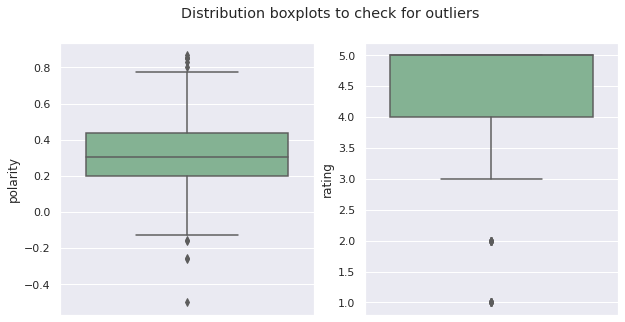

In [17]:
# check for any outliers
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(y=polarity_check.polarity, ax=ax1)
sns.boxplot(y=polarity_check.rating, ax=ax2)
fig.suptitle('Distribution boxplots to check for outliers')

plt.show()

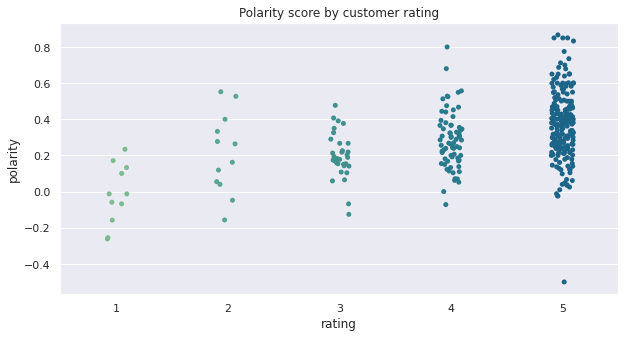

In [18]:
# scatter plot of polarity by rating
fig, ax = plt.subplots(figsize=(10, 5))

sns.stripplot(x='rating', y='polarity', data=data, hue='rating')
ax.legend_=None
ax.set_title('Polarity score by customer rating')

plt.show()

An outlier is clearly visible on the plot: it is the review that was inconsistent in the 5 worst reviews of our dataset sorted by polarity. 

In [19]:
# drop visible outlier with high rating and negative polarity
outlier = polarity_check.polarity.idxmin()
data.drop(outlier, inplace=True)

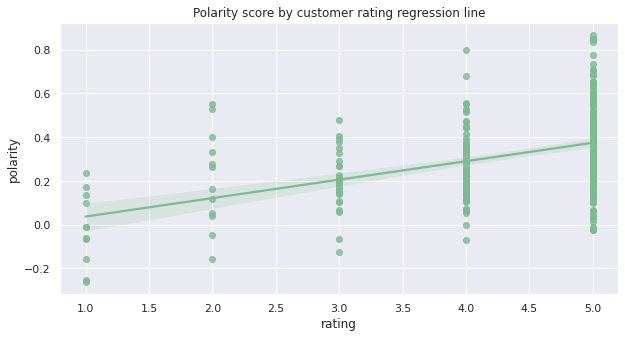

In [20]:
# regression plot of polarity by rating

fig, ax = plt.subplots(figsize=(10, 5))

sns.regplot(x='rating', y='polarity', data=data, ci=95)
ax.set_title('Polarity score by customer rating regression line')

plt.show()

Regression plot shows uneven distribution of rating scores, which makes the polarity score even harder to relate to rating. Let's group polarity score by rating score. 

In [21]:
# group polarity scores by rating and average them
rating_gp = pd.DataFrame(data.groupby('rating', as_index=False)['polarity'].mean().round(3).sort_values(by='rating', ascending=True))
rating_gp

,rating,polarity
0,1,-0.017
1,2,0.210
2,3,0.199
3,4,0.284
4,5,0.375


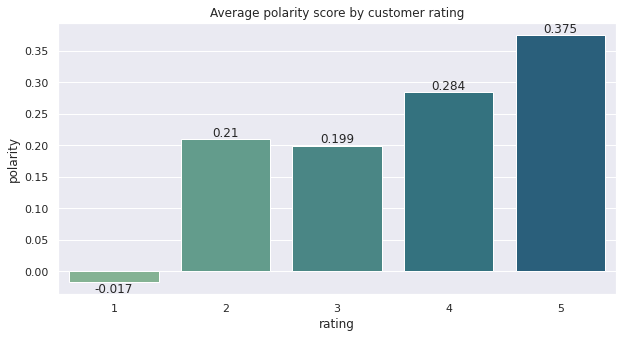

In [22]:
# bar plot polarity by rating

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x='rating', y='polarity', data=rating_gp)
ax.bar_label(ax.containers[0])
ax.set_title('Average polarity score by customer rating')

plt.show()

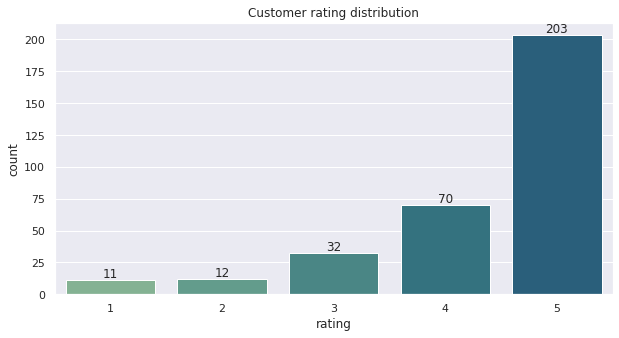

In [23]:
# comparing with ratings distribution (out of 5)
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(data=data, x='rating', ax=ax)
ax.bar_label(ax.containers[0])
ax.set_title('Customer rating distribution')

plt.show()

Let's compute polarity scores vs ratings by deciles to further compare distributions.

In [24]:
# check deciles scores
polarity_check.quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

,polarity,rating
0.1,0.0926,3.0
0.2,0.1686,4.0
0.3,0.2184,4.0
0.4,0.2654,5.0
0.5,0.3070,5.0
0.6,0.3658,5.0
0.7,0.4062,5.0
0.8,0.4670,5.0
0.9,0.5590,5.0


## Word cloud visualization

### CountVectorizer

In [25]:
# Creating Document Term Matrix with bigrams (grouped expressions of words)
cv = CountVectorizer(analyzer='word', ngram_range=(1, 2))
l = cv.fit_transform(data['lemmatized'])
lemma = pd.DataFrame(l.toarray(), columns=cv.get_feature_names_out())
lemma.index = data.index
lemma.head()

,aback,aback get,abandon,abandon star,able,able answer,able appreciate,able dine,able dinner,able excite,able explain,able make,able meet,able minute,able reservation,able score,able secure,able select,able snag,able speak,able table,able watch,able wife,able worth,aboutthere,aboutthere well,aboveaverage,aboveaverage experience,abroad,abroad feel,abroad let,absence,absence unfortunatelly,absolute,absolute best,absolute magicfinishe,absolute shame,absolutely,absolutely class,absolutely delicious,...,york,york times,young,young bertrand,young canadian,young chef,young crew,young energeticdef,young friendly,young helpful,young hip,young lady,young man,young one,young orient,young original,young people,young poise,young professional,young smart,young staff,young wet,yummore,yummy,yummy good,yummy pigeon,yummy thank,zest,zest surprisingly,zombie,zombie reservation,zone,zone control,zone headmind,zucchini,zucchini awful,zucchini cheese,zucchini lightly,zucchini pear,zucchini unusual
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [26]:
# extract a list of 20 most occuring words
frequency = lemma.sum()
top_20 = frequency.sort_values(ascending=False)[:20]
top_20.index.to_list()
top_20

food           271
good           253
wine           209
menu           187
course         177
reservation    159
dish           157
service        149
paris          149
lunch          147
not            138
table          127
great          121
meal           109
time           109
staff          103
place           98
experience      91
like            84
taste           81
dtype: int64

The most occurring words also feature some irrelevant words like 'not', but essential for sentiment analysis. The list also mixes positive ('good') and negative ('time') features altogether and cannot be used as is.

### Extract extreme values reviews

To summarize the best reviews and the worst reviews, it seems fair to compare word clouds by polarity and by rating scores.

In [27]:
# first extract worst and best 10% reviews by polarity score
worst = data[data['polarity']<0.0994]
best = data[data['polarity']>0.5600]

print(len(worst), len(best))

33 33


In [28]:
# extract bad and good reviews according to score
bad = data[data['rating']<=3]
good = data[data['rating']==5]

print(len(bad), len(good))

55 203


Let's plot wordclouds of good and bad reviews in different shapes to make things clearer to visualize. 

In [29]:
# define a function to generate wordclouds from dataframes
def wordclouding(df, pic, palette):
  text = df.lemmatized.tolist()
  text = ' '.join(text)
  wordcloud = WordCloud(stopwords = STOPWORDS, 
                        collocations=True, 
                        width = 800, height = 800,
                        background_color='white', 
                        colormap=palette, 
                        mask=pic, 
                        ).generate(text)
  plt.figure(figsize = (10, 10)) 
  plt.imshow(wordcloud, 
             interpolation='bilInear'
             ) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  plt.show()

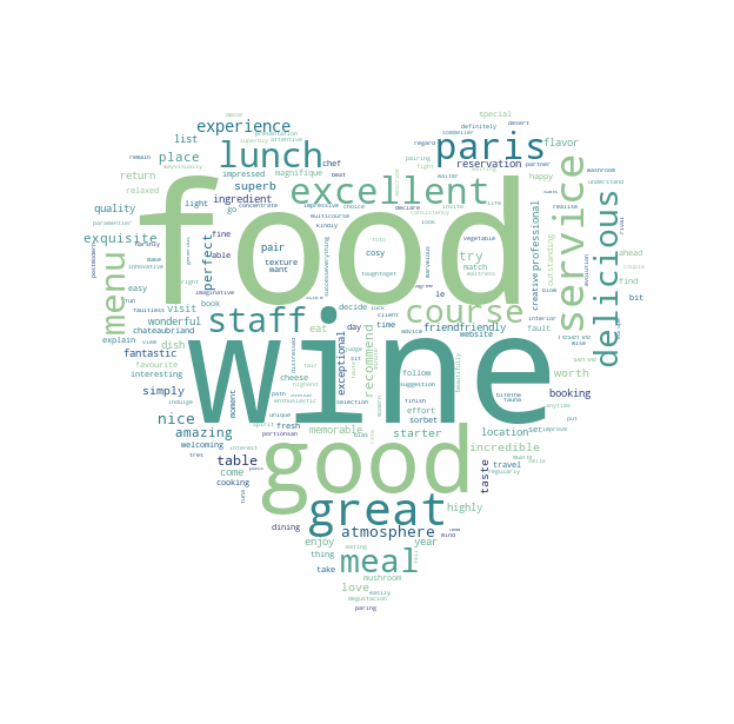

In [31]:
# compute 'best' wordcloud
url = 'https://media.istockphoto.com/vectors/heart-symbol-of-love-and-valentines-day-flat-red-icon-isolated-on-vector-id1128400054?b=1&k=20&m=1128400054&s=612x612&w=0&h=TeuKynPXDifmp5MUm1MsnM4wpmInK80tVBSlv3z3dtc='
heart = np.array(Image.open(requests.get(url, stream=True).raw))
wordclouding(best, heart, 'crest')

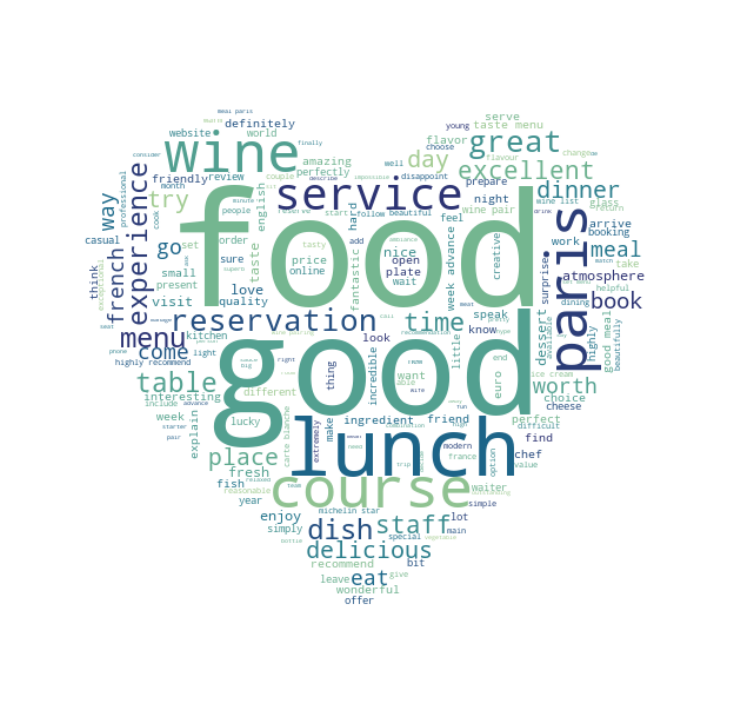

In [32]:
# compute 'good' wordcloud
wordclouding(good, heart, 'crest')

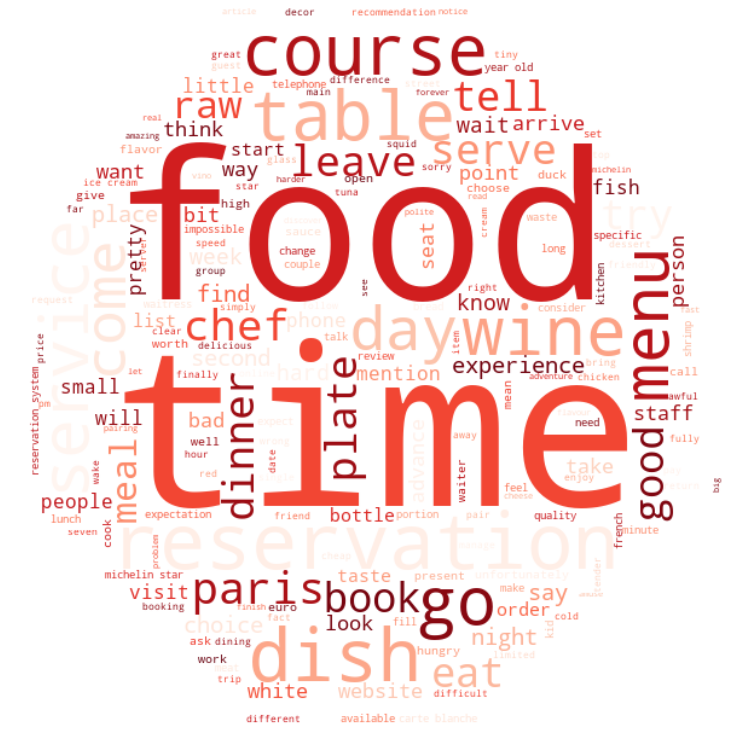

In [34]:
# compute 'worst' wordcloud
url = 'http://clipart-library.com/images/8iGbbB7aT.png'
stop = np.array(Image.open(requests.get(url, stream=True).raw))
wordclouding(worst, stop, 'Reds')

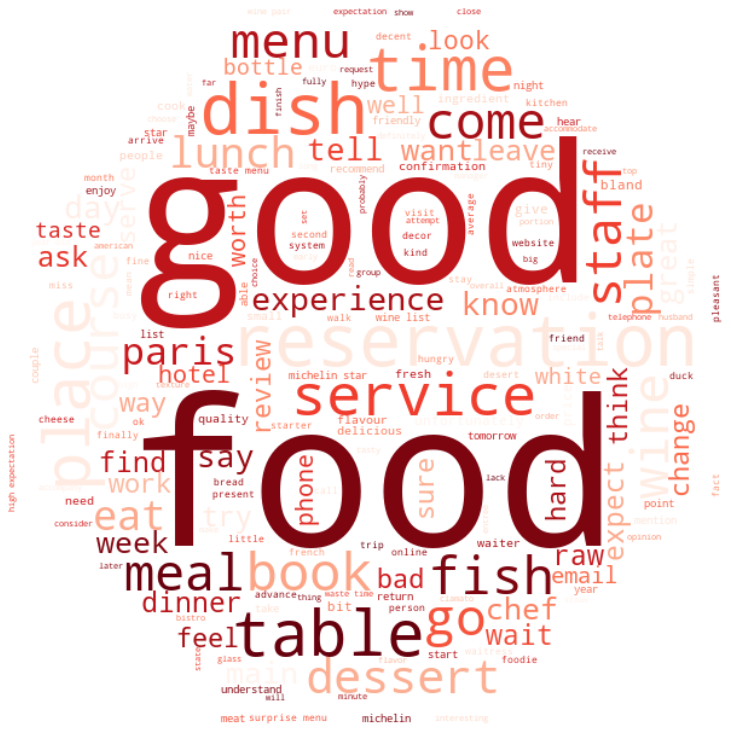

In [36]:
# compute 'bad' wordcloud
wordclouding(bad, stop, 'Reds')

### Tokenized text Wordcloud

Alternative, shorter method to plot overall reviews wordcloud.

In [37]:
# tokenize reviews text and turn it into a single string
all_text = '' 
stopwords = set(STOPWORDS)

for word in data.lemmatized:
    word = str(word) 
    tokens = word.split() 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    all_text += " ".join(tokens)+" "

all_text

'lucky enjoy food time recommend vegetarian look quality michelin experience dish vegetarian easily adjust menu ask accommodating allergy andpreference broccoli smell like steak taste better broccoli end day prefer meat think enjoy wine pairing lean heavily natural wine liking enjoy orange wines trend paris visit tuesday wait long time list forever go taste menu bottle wine go big food trip visit ogata pavyllon have see wine list order bottle white waitress come bottle red problem change time course meal start go wrong speed service start way fast notice hovering service plate polite service bad refill wine glass focused plate food soso talk bistro talk michelin star s close expectation quality food leave finish meal mention fact speed service lack service manager start disagree tell chef want let clear thing speed service hostess chef come awful experience bill € food michelin star visit bouillon chartier want eat fast service superb theremore get reservation couple month covid lockdo

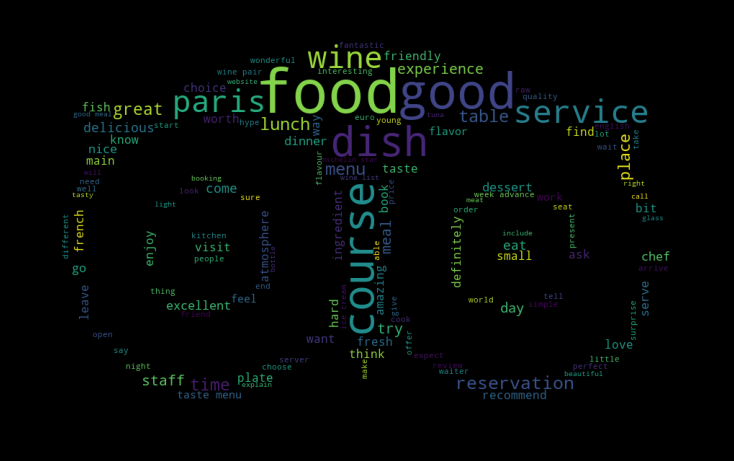

<Figure size 432x288 with 0 Axes>

In [38]:
# plot wordcloud
pic = np.array(Image.open(requests.get('https://hospitality-on.com/sites/default/files/import/contenu/tripadvisor.png',stream=True).raw))
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, mask = pic, 
                colormap='viridis', 
                min_font_size = 10).generate(all_text)

plt.figure(figsize = (10, 10), facecolor = 'black', edgecolor='blue') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()
plt.savefig('Owl_cloud.png')

Additional features to customize wordcloud

In [ ]:
'''
# use ImageColorGenerator to generate the colors from the image
image_colors = ImageColorGenerator(color_mask)

# use the new colors to color the wordcloud
wordcloud.recolor(color_func = image_colors)
'''

'\n# use ImageColorGenerator to generate the colors from the image\nimage_colors = ImageColorGenerator(color_mask)\n\n# use the new colors to color the wordcloud\nwordcloud.recolor(color_func = image_colors)\n'